In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
net = NeuralNet()
net.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.004, momentum=0.9)

print("Starting Training...")
for epoch in range(30):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.5f}')

print('Finished Training')
torch.save(net.state_dict(), 'trained_net.pth')

Starting Training...
Epoch 1, Loss: 1.83369
Epoch 2, Loss: 1.38304
Epoch 3, Loss: 1.18825
Epoch 4, Loss: 1.05272
Epoch 5, Loss: 0.95422
Epoch 6, Loss: 0.87802
Epoch 7, Loss: 0.81494
Epoch 8, Loss: 0.76167
Epoch 9, Loss: 0.70961
Epoch 10, Loss: 0.66679
Epoch 11, Loss: 0.61977
Epoch 12, Loss: 0.58467
Epoch 13, Loss: 0.55185
Epoch 14, Loss: 0.51767
Epoch 15, Loss: 0.49361
Epoch 16, Loss: 0.46282
Epoch 17, Loss: 0.42838
Epoch 18, Loss: 0.41261
Epoch 19, Loss: 0.38855
Epoch 20, Loss: 0.37747
Epoch 21, Loss: 0.35553
Epoch 22, Loss: 0.34023
Epoch 23, Loss: 0.33111
Epoch 24, Loss: 0.31030
Epoch 25, Loss: 0.30319
Epoch 26, Loss: 0.29153
Epoch 27, Loss: 0.28127
Epoch 28, Loss: 0.27428
Epoch 29, Loss: 0.26384
Epoch 30, Loss: 0.25871
Finished Training


In [5]:
model = NeuralNet()
model.load_state_dict(torch.load('trained_net.pth'))
model.to(device)
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 66.80 %


In [6]:
def load_image(image_path):
    new_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert('RGB')
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

image_paths = ['dog.jpg', 'plane.jpg']
images = [load_image(img) for img in image_paths]

inference_model = NeuralNet()
inference_model.load_state_dict(torch.load('trained_net.pth'))
inference_model.to(device)
inference_model.eval()

with torch.no_grad():
    for image in images:
        image = image.to(device)
        output = inference_model(image)
        _, predicted = torch.max(output, 1)
        print(f'Prediction: {class_names[predicted.item()]}')

Prediction: dog
Prediction: truck


#### Now I don't much about model's accuracy at this point of time but capping at 64-65% was just not great
#### So, from the readme file and also from the paper I decided to experiment with actually coding the model's dropout approach where we just randomly turn off some % of neurons for each training step 


In [7]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Classifier
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [8]:
# Use the new model
net = ImprovedNet()
net.to(device)
loss_function = nn.CrossEntropyLoss()

# You can also try the Adam optimizer, which often works well
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Add the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

# In your training loop, after the optimizer.step(), add:
for epoch in range(30):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.5f}')

print('Finished Training')
torch.save(net.state_dict(), 'trained_net1.pth')

Epoch 1, Loss: 1.63031
Epoch 2, Loss: 1.26508
Epoch 3, Loss: 1.10129
Epoch 4, Loss: 0.99242
Epoch 5, Loss: 0.92116
Epoch 6, Loss: 0.85828
Epoch 7, Loss: 0.79886
Epoch 8, Loss: 0.75841
Epoch 9, Loss: 0.71423
Epoch 10, Loss: 0.66879
Epoch 11, Loss: 0.63871
Epoch 12, Loss: 0.60094
Epoch 13, Loss: 0.56967
Epoch 14, Loss: 0.54176
Epoch 15, Loss: 0.51398
Epoch 16, Loss: 0.48930
Epoch 17, Loss: 0.46251
Epoch 18, Loss: 0.43769
Epoch 19, Loss: 0.41592
Epoch 20, Loss: 0.39153
Epoch 21, Loss: 0.38179
Epoch 22, Loss: 0.36041
Epoch 23, Loss: 0.34923
Epoch 24, Loss: 0.33744
Epoch 25, Loss: 0.32577
Epoch 26, Loss: 0.31280
Epoch 27, Loss: 0.30061
Epoch 28, Loss: 0.29185
Epoch 29, Loss: 0.28603
Epoch 30, Loss: 0.27280
Finished Training


In [9]:
model = ImprovedNet()
model.load_state_dict(torch.load('trained_net1.pth'))
model.to(device)
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 84.45 %


In [10]:
def load_image(image_path):
    new_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert('RGB')
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

image_paths = ['dog.jpg', 'plane.jpg']
images = [load_image(img) for img in image_paths]

inference_model1 = ImprovedNet()
inference_model1.load_state_dict(torch.load('trained_net1.pth'))
inference_model1.to(device)
inference_model1.eval()

with torch.no_grad():
    for image in images:
        image = image.to(device)
        output = inference_model1(image)
        _, predicted = torch.max(output, 1)
        print(f'Prediction: {class_names[predicted.item()]}')

Prediction: dog
Prediction: plane


#### I did want to stop here but I just had to try with data augmentation as well to check the accuracy spikes with both approaches mentioned in the paper

In [13]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
class ImprovedNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [15]:
net2 = ImprovedNet2()
net2.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

print("Starting Training...")
for epoch in range(75):
    running_loss = 0.0
    net2.train()
    
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.5f}')
    scheduler.step()

print('Finished Training')

Starting Training...
Epoch 1, Loss: 1.80733
Epoch 2, Loss: 1.49310
Epoch 3, Loss: 1.33670
Epoch 4, Loss: 1.21884
Epoch 5, Loss: 1.14128
Epoch 6, Loss: 1.08649
Epoch 7, Loss: 1.03787
Epoch 8, Loss: 0.99637
Epoch 9, Loss: 0.96265
Epoch 10, Loss: 0.92655
Epoch 11, Loss: 0.89566
Epoch 12, Loss: 0.86057
Epoch 13, Loss: 0.83356
Epoch 14, Loss: 0.80085
Epoch 15, Loss: 0.77272
Epoch 16, Loss: 0.74948
Epoch 17, Loss: 0.73220
Epoch 18, Loss: 0.69859
Epoch 19, Loss: 0.68718
Epoch 20, Loss: 0.66461
Epoch 21, Loss: 0.64334
Epoch 22, Loss: 0.62850
Epoch 23, Loss: 0.61598
Epoch 24, Loss: 0.59902
Epoch 25, Loss: 0.58596
Epoch 26, Loss: 0.53337
Epoch 27, Loss: 0.51406
Epoch 28, Loss: 0.50838
Epoch 29, Loss: 0.49951
Epoch 30, Loss: 0.49824
Epoch 31, Loss: 0.48926
Epoch 32, Loss: 0.48556
Epoch 33, Loss: 0.48357
Epoch 34, Loss: 0.48435
Epoch 35, Loss: 0.47747
Epoch 36, Loss: 0.47202
Epoch 37, Loss: 0.47217
Epoch 38, Loss: 0.46571
Epoch 39, Loss: 0.46945
Epoch 40, Loss: 0.46203
Epoch 41, Loss: 0.45559
Epoc

In [16]:
net2.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net2(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 86.96 %


Training Baseline NeuralNet...
Epoch 1/20, Train Loss: 1.5891, Val Accuracy: 49.58%
Epoch 2/20, Train Loss: 1.2274, Val Accuracy: 58.66%
Epoch 3/20, Train Loss: 1.0758, Val Accuracy: 61.89%
Epoch 4/20, Train Loss: 0.9837, Val Accuracy: 63.94%
Epoch 5/20, Train Loss: 0.9133, Val Accuracy: 65.03%
Epoch 6/20, Train Loss: 0.8618, Val Accuracy: 66.66%
Epoch 7/20, Train Loss: 0.8123, Val Accuracy: 66.34%
Epoch 8/20, Train Loss: 0.7688, Val Accuracy: 67.23%
Epoch 9/20, Train Loss: 0.7266, Val Accuracy: 67.48%
Epoch 10/20, Train Loss: 0.6932, Val Accuracy: 67.87%
Epoch 11/20, Train Loss: 0.6636, Val Accuracy: 67.82%
Epoch 12/20, Train Loss: 0.6258, Val Accuracy: 68.27%
Epoch 13/20, Train Loss: 0.6065, Val Accuracy: 67.40%
Epoch 14/20, Train Loss: 0.5770, Val Accuracy: 67.81%
Epoch 15/20, Train Loss: 0.5540, Val Accuracy: 67.82%
Epoch 16/20, Train Loss: 0.5265, Val Accuracy: 67.68%
Epoch 17/20, Train Loss: 0.5050, Val Accuracy: 67.87%
Epoch 18/20, Train Loss: 0.4836, Val Accuracy: 67.62%
Epoch 

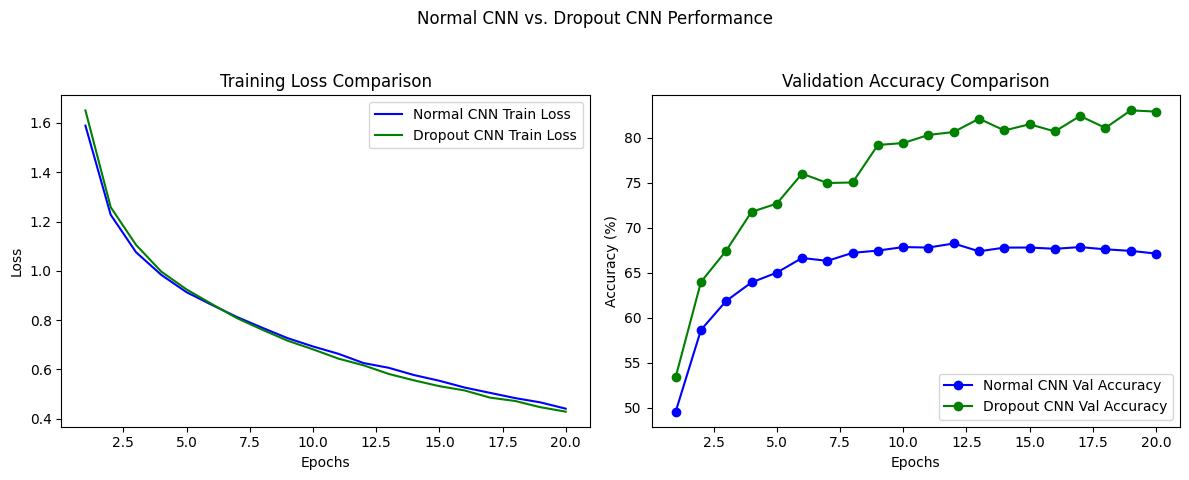

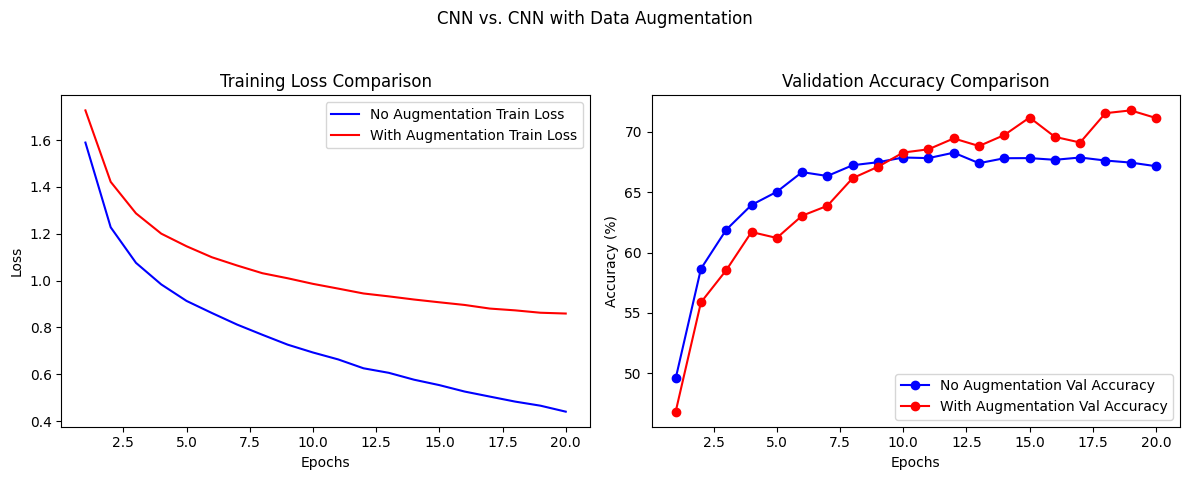

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set_basic = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=basic_transform)
train_set_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=basic_transform)

train_loader_basic = torch.utils.data.DataLoader(train_set_basic, batch_size=64, shuffle=True)
train_loader_augmented = torch.utils.data.DataLoader(train_set_augmented, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

def train_and_evaluate(model, train_loader, test_loader, num_epochs=20):
    model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = {'train_loss': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        history['val_accuracy'].append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
    return history

print("Training Baseline NeuralNet...")
baseline_model = NeuralNet()
baseline_history = train_and_evaluate(baseline_model, train_loader_basic, test_loader)

print("\nTraining ImprovedNet (with Dropout/BN)...")
dropout_model = ImprovedNet()
dropout_history = train_and_evaluate(dropout_model, train_loader_basic, test_loader)

print("\nTraining NeuralNet with Data Augmentation...")
augmentation_model = NeuralNet()
augmentation_history = train_and_evaluate(augmentation_model, train_loader_augmented, test_loader)

epochs = range(1, 21)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, baseline_history['train_loss'], 'b-', label='Normal CNN Train Loss')
plt.plot(epochs, dropout_history['train_loss'], 'g-', label='Dropout CNN Train Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, baseline_history['val_accuracy'], 'b-o', label='Normal CNN Val Accuracy')
plt.plot(epochs, dropout_history['val_accuracy'], 'g-o', label='Dropout CNN Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.suptitle('Normal CNN vs. Dropout CNN Performance')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('dropout_comparison.png')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, baseline_history['train_loss'], 'b-', label='No Augmentation Train Loss')
plt.plot(epochs, augmentation_history['train_loss'], 'r-', label='With Augmentation Train Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, baseline_history['val_accuracy'], 'b-o', label='No Augmentation Val Accuracy')
plt.plot(epochs, augmentation_history['val_accuracy'], 'r-o', label='With Augmentation Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.suptitle('CNN vs. CNN with Data Augmentation')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('augmentation_comparison.png')

print("\nPlots saved as 'dropout_comparison.png' and 'augmentation_comparison.png'")